In [1]:
from templates import *

c:\Users\dmrar\Desktop\WS23-24\computational surgineering\env-diffae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SyntaxError: invalid syntax (dataset.py, line 816)

: 

In [3]:
device = 'cuda'
conf = mixed_us_training()
# print(conf.name)
model = LitModel(conf)
state = torch.load(R'checkpoints\mixed_cosine\last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

Global seed set to 0
Global seed set to 0


Model params: 91.89 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=64, bias=True)
     

In [12]:
data = RealUSDataset(R'datasets\filtered')
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

In [13]:
len(data)

7866

In [29]:
# make pytroch dataloader
loader = DataLoader(data, batch_size=128, shuffle=False)

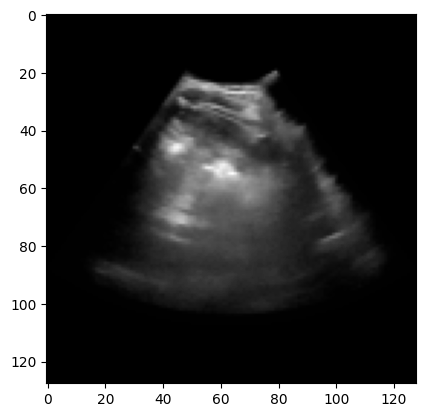

In [15]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]), cmap='gray')

In [38]:
img_encodings = {}
for i, batch in enumerate(loader):
    cond = model.encode(batch['img'].to('cuda'))
    for j in range(cond.shape[0]):
        # print(i * 128 + j)
        img_encodings[i * 128 + j] = cond[j].detach().cpu().numpy()

In [46]:
import numpy as np

def cosine_similarity_matrix(X):
    # Compute dot product of all pairs of vectors
    dot_product = np.dot(X, X.T)
    # Compute the norm of each vector
    norm = np.linalg.norm(X, axis=1)
    # Compute the outer product of norms
    norm_outer = np.outer(norm, norm)
    # Compute cosine similarity matrix
    similarity_matrix = dot_product / norm_outer
    return similarity_matrix

def euclidean_distance_matrix(X):
    # Compute pairwise Euclidean distances
    distances = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=-1))
    return distances

In [60]:
latent_representations_array = np.array(list(img_encodings.values()))
cosine_similarity = cosine_similarity_matrix(latent_representations_array)
# euclidean_distance = euclidean_distance_matrix(latent_representations_array)

def find_top_similar_cosine(similarity_matrix, top_x):
    np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal elements to -infinity to exclude self-similarity
    indices = np.argpartition(similarity_matrix.flatten(), -top_x)[-top_x:]
    top_indices = np.unravel_index(indices, similarity_matrix.shape)
    return top_indices

# Example usage:
top_x = 50
top_indices_cosine = find_top_similar_cosine(cosine_similarity, top_x)
print("Indices of the top", top_x, "most similar vectors (Cosine Similarity):", top_indices_cosine)


Indices of the top 50 most similar vectors (Cosine Similarity): (array([3217, 3219, 2735, 5992, 3620, 2953, 5993, 6175, 6174, 2734, 2952,
       6021, 6022, 3619, 3218, 3218, 6858, 5947, 6857, 3217,  131,  131,
        128, 3219,  128,  128, 5946,  129,  129,  129, 3183, 3184, 3216,
       6032, 3211, 6827, 4717, 7636, 3215,  130, 3212, 6031,  130, 6826,
       2203, 2202, 7635, 4716,  130,  131], dtype=int64), array([3219, 3217, 2734, 5993, 3619, 2952, 5992, 6174, 6175, 2735, 2953,
       6022, 6021, 3620, 3219, 3217, 6857, 5946, 6858, 3218,  128,  130,
        129, 3218,  130,  131, 5947,  128,  130,  131, 3184, 3183, 3215,
       6031, 3212, 6826, 4716, 7635, 3216,  128, 3211, 6032,  129, 6827,
       2202, 2203, 7636, 4717,  131,  129], dtype=int64))


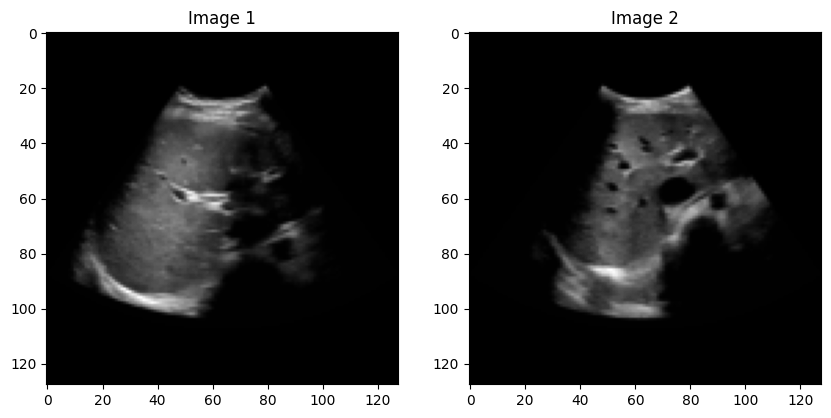

In [62]:
img1 = data[2735] 
img2 = data[3219]

#create a figure to display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#display the first image
axes[0].imshow(img1['img'].permute([1, 2, 0]), cmap='gray')
axes[0].set_title('Image 1')
#display the second image
axes[1].imshow(img2['img'].permute([1, 2, 0]), cmap='gray')
axes[1].set_title('Image 2')
plt.show()


torch.Size([2, 512])


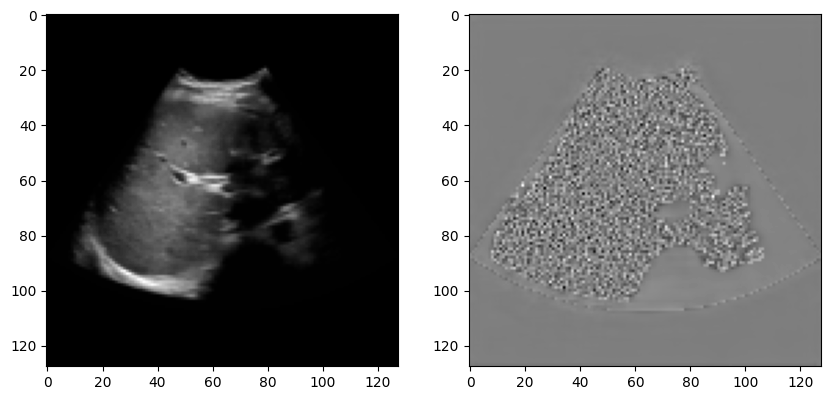

In [70]:
cond1 = img_encodings[2735]
cond2 = img_encodings[3219]
cond = torch.stack([torch.tensor(cond1), torch.tensor(cond2)]).to('cuda')
print(cond.shape)
batch = torch.stack([
    img1['img'],
    img2['img'],
])

xT = model.encode_stochastic(batch.to(device), cond, T=1000)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(xT[0].permute(1, 2, 0).cpu(), cmap='gray')

In [71]:
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=1000)

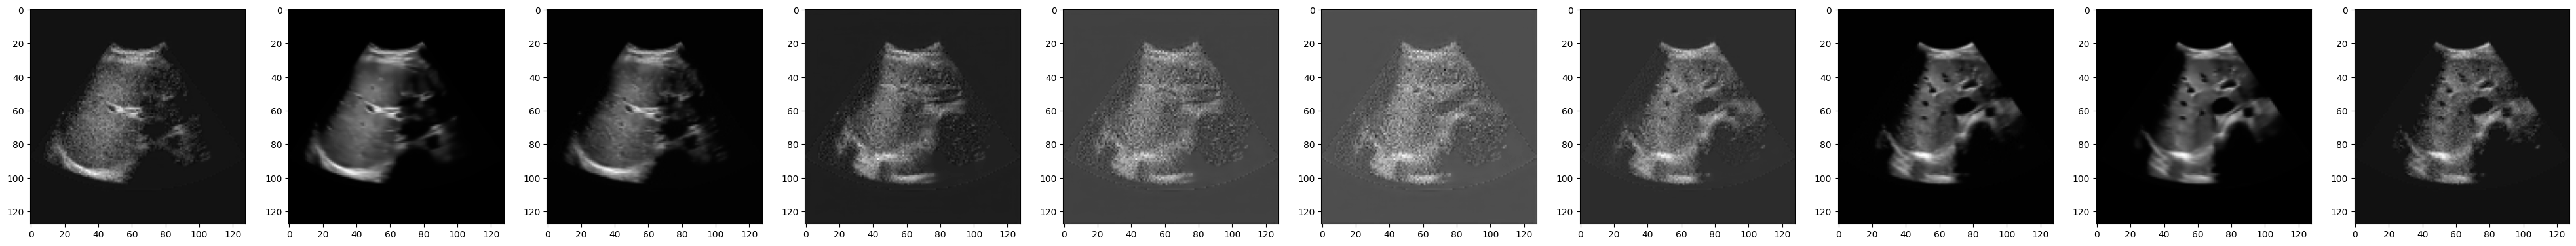

: 

In [72]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu(), cmap='gray')